In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
import optuna as optuna # for hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
import shape # for model interpretability

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
df = pd.read_csv("../data/cleaned_data.csv") 
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1
1,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0
2,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0
3,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0
4,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0


In [5]:
X = df.drop("Exited", axis=1)
y = df["Exited"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
num_var = X.select_dtypes(include=["float64", "int64"]).columns
cat_var = X.select_dtypes(include=["object"]).columns


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
    ]
)

In [ ]:
# Logistic Regression Model
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train and evaluate Logistic Regression
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]


In [ ]:
# Evaluation function
def evaluate_model(y_test, y_pred, y_prob):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()


Accuracy: 0.8103333333333333
Precision: 0.515986769570011
Recall: 0.782608695652174
F1-score: 0.6219269102990034
AUC: 0.8855942233200315

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      2402
           1       0.52      0.78      0.62       598

    accuracy                           0.81      3000
   macro avg       0.73      0.80      0.75      3000
weighted avg       0.85      0.81      0.82      3000



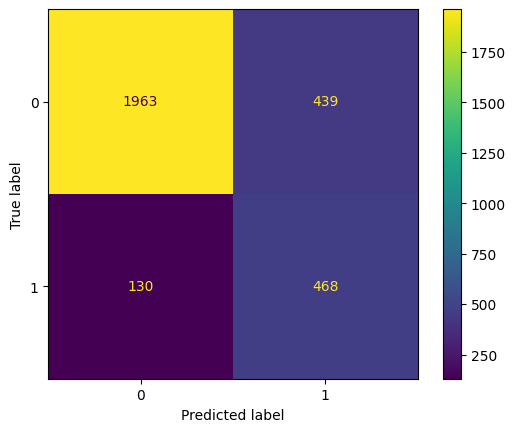

In [11]:
evaluate_model(y_test, y_pred, y_prob)

Accuracy: 0.8823333333333333
Precision: 0.6798825256975036
Recall: 0.774247491638796
F1-score: 0.7240031274433151
AUC: 0.9296196870500892

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2402
           1       0.68      0.77      0.72       598

    accuracy                           0.88      3000
   macro avg       0.81      0.84      0.82      3000
weighted avg       0.89      0.88      0.89      3000



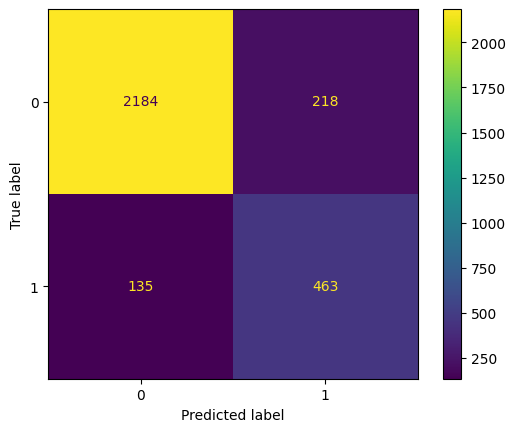

In [12]:
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

evaluate_model(y_test, y_pred_rf, y_prob_rf)


Accuracy: 0.8813333333333333
Precision: 0.6713881019830028
Recall: 0.7926421404682275
F1-score: 0.7269938650306749
AUC: 0.9316414136491608

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2402
           1       0.67      0.79      0.73       598

    accuracy                           0.88      3000
   macro avg       0.81      0.85      0.83      3000
weighted avg       0.89      0.88      0.88      3000



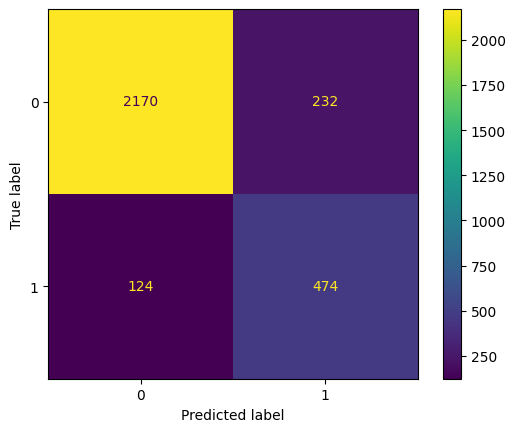

In [ ]:
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,   # gérer déséquilibre
        eval_metric='logloss',
        random_state=42
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

evaluate_model(y_test, y_pred_xgb, y_prob_xgb)


# Feauture selection
# Select the beste optimization methode between gridsearch and optuna
# validation croise pour deteimer la bon methode 